In [ ]:
# House Price Regression - baseline workflow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.style.use('seaborn-v0_8')

In [ ]:
data_file = '/content/house_price_regression_dataset.csv'
df = pd.read_csv(data_file)
df.shape,df.columns[:10]


((1000, 8),
 Index(['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Year_Built',
        'Lot_Size', 'Garage_Size', 'Neighborhood_Quality', 'House_Price'],
       dtype='object'))

In [ ]:
df.head()

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360,2,1,1981,0.599637,0,5,2.623829e+05
1,4272,3,3,2016,4.753014,1,6,9.852609e+05
2,3592,1,2,2016,3.634823,0,9,7.779774e+05
3,966,1,2,1977,2.730667,1,8,2.296989e+05
4,4926,2,1,1993,4.699073,0,8,1.041741e+06


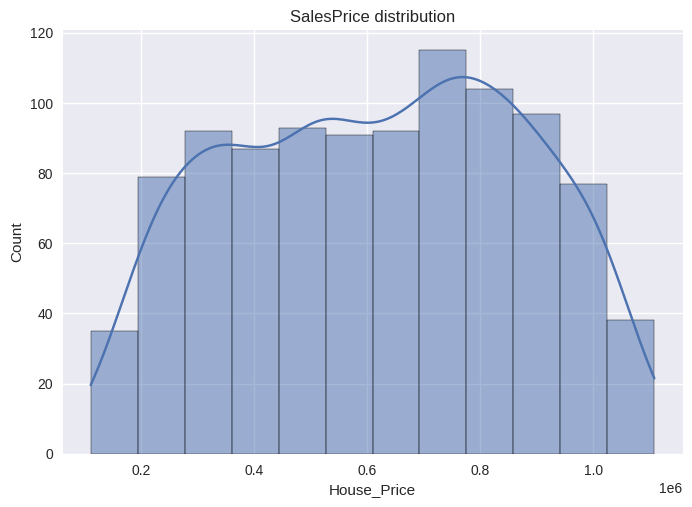

Skewness: -0.06395513907654668


,0


In [ ]:
#quick EDA: target & missing
sns.histplot(df['House_Price'], kde = True)
plt.title('SalesPrice distribution')
plt.show()

print('Skewness:',df['House_Price'].skew())

missing = df.isnull().sum().sort_values(ascending = False)
missing[missing>0].head()


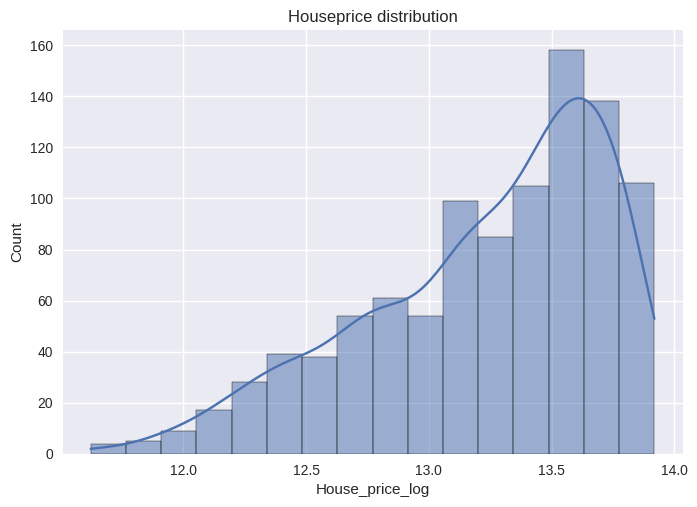

In [ ]:
#simple target transform
# target log transform reduces skew and helps models

df['House_price_log'] = np.log1p(df['House_Price'])
sns.histplot(df['House_price_log'], kde = True)
plt.title('Houseprice distribution')
plt.show()

In [ ]:
#choose features (simple baseline)
features = ['Square_Footage',	'Num_Bedrooms',	'Num_Bathrooms',	'Year_Built',	'Lot_Size',	'Garage_Size',	'Neighborhood_Quality']
target = 'House_price_log'
data = df[features + [target]].copy()
data.head()

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_price_log
0,1360,2,1,1981,0.599637,0,5,12.477564
1,4272,3,3,2016,4.753014,1,6,13.800663
2,3592,1,2,2016,3.634823,0,9,13.564454
3,966,1,2,1977,2.730667,1,8,12.344529
4,4926,2,1,1993,4.699073,0,8,13.856405


In [ ]:
#train/test split
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train.shape, X_test.shape

((800, 7), (200, 7))

In [ ]:
#preprocessing pipelines
# numeric features (we used only numerics here)

numeric_features = features

numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

preprocessing = ColumnTransformer(transformers = [
    ('num', numeric_transformer, numeric_features)
])

In [ ]:
model = Pipeline(steps = [
    ('preprocessor', preprocessing),
    ('regressor', LinearRegression())
])

model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Square_Footage',
                                                   'Num_Bedrooms',
                                                   'Num_Bathrooms',
                                                   'Year_Built', 'Lot_Size',
                                                   'Garage_Size',
                                                   'Neighborhood_Quality'])])),
                ('regressor', LinearRegression())])

In [ ]:
#evaluate baseline
def rmse(y_true,y_pred):
  return np.sqrt(mean_absolute_error(y_true,y_pred))

y_pred = model.predict(X_test)
print('RMSE:', rmse(y_pred, y_test))
print('MAE:', mean_absolute_error(y_pred, y_test))
print('R2:', r2_score(y_pred, y_test))

RMSE: 0.30130135846911443
MAE: 0.09078250861533381
R2: 0.9426690754408186


In [ ]:
# back to original scale
y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred)
print("MAE(orig):", mean_absolute_error(y_test_orig, y_pred_orig))
print("RMSE(orig):", np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)))


MAE(orig): 51521.69374178376
RMSE(orig): 66971.30989367235


In [ ]:
#cross-validation

cv = KFold(n_splits = 5,shuffle = True, random_state = 42)
cv_scores = cross_val_score(model, X, y, scoring = 'neg_root_mean_squared_error', cv = cv)
print("5-fold CV RMSE (log scale):", -cv_scores, 'mean', -cv_scores.mean())

5-fold CV RMSE (log scale): [0.11367941 0.11414599 0.13001176 0.12335299 0.11748325] mean 0.11973467879396535


In [ ]:
#try a stronger model (RandomForest)
rf_model = Pipeline(steps = [
    ('preprocessor', preprocessing),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state = 42, n_jobs = -1))
])
rf_model.fit(X_train,y_train)
y_pred_rf = rf_model.predict(X_test)
print('RMSE:', rmse(y_pred_rf, y_test))
print('MAE:', mean_absolute_error(y_pred_rf, y_test))
print('R2:', r2_score(y_pred_rf, y_test))

RMSE: 0.1811265890494027
MAE: 0.03280684126067121
R2: 0.9913610309648353


In [ ]:
#feature importance (from RF)
importances = rf_model.named_steps['regressor'].feature_importances_

for f,imp in sorted(zip(features,importances), key = lambda x:x[1], reverse = True):
  print(f, round(imp,4))

Square_Footage 0.9806
Year_Built 0.0077
Lot_Size 0.0065
Num_Bedrooms 0.0026
Neighborhood_Quality 0.0012
Num_Bathrooms 0.0008
Garage_Size 0.0006
